Diabetes is a condition that carries an increased risk of developing eye complications. Diabetic eye disease includes complications such as diabetic retinopathy, cataracts and glaucoma.

Diabetes is the leading cause of blindness in working-age adults. People with type 1 and type 2 diabetes are at risk. It’s possible to be unaware that you have severe diabetic eye disease and suddenly go blind. Fortunately, most cases of blindness can be prevented with regular eye examinations and proper care.

The dataset consists of Normal, Diabetic Retinopathy, Cataract and Glaucoma retinal images where each class have approximately 1000 images. These images are collected from various sorces like IDRiD, Oculur recognition, HRF etc.

- Diabetic retinopathy:
The persistently high blood sugar levels that occur with diabetes can damage the retina’s small blood vessels (capillaries), which deliver oxygen and nutrients. Diabetic retinopathy affects up to a third of people with diabetes over the age of 502.

- Cataracts:
A cataract is a clouding of the lens in the eye. Left untreated, cataracts can eventually lead to blindness. People with diabetes are more likely to develop cataracts at an earlier age and suffer visual impairment faster than those without the condition.1,3

- Glaucoma:
This is a group of conditions that can damage the optic nerve. The optic nerve transmits signals from the retina to the brain for processing. Glaucoma is often (but not always) a result of increased pressure inside the eye. The risk of glaucoma in people with diabetes is significantly higher than that of the general population.1,4 The two main types are open-angle glaucoma (also called ‘the sneak thief of sight’) and angle-closure glaucoma (this comes on suddenly and is a medical emergency).

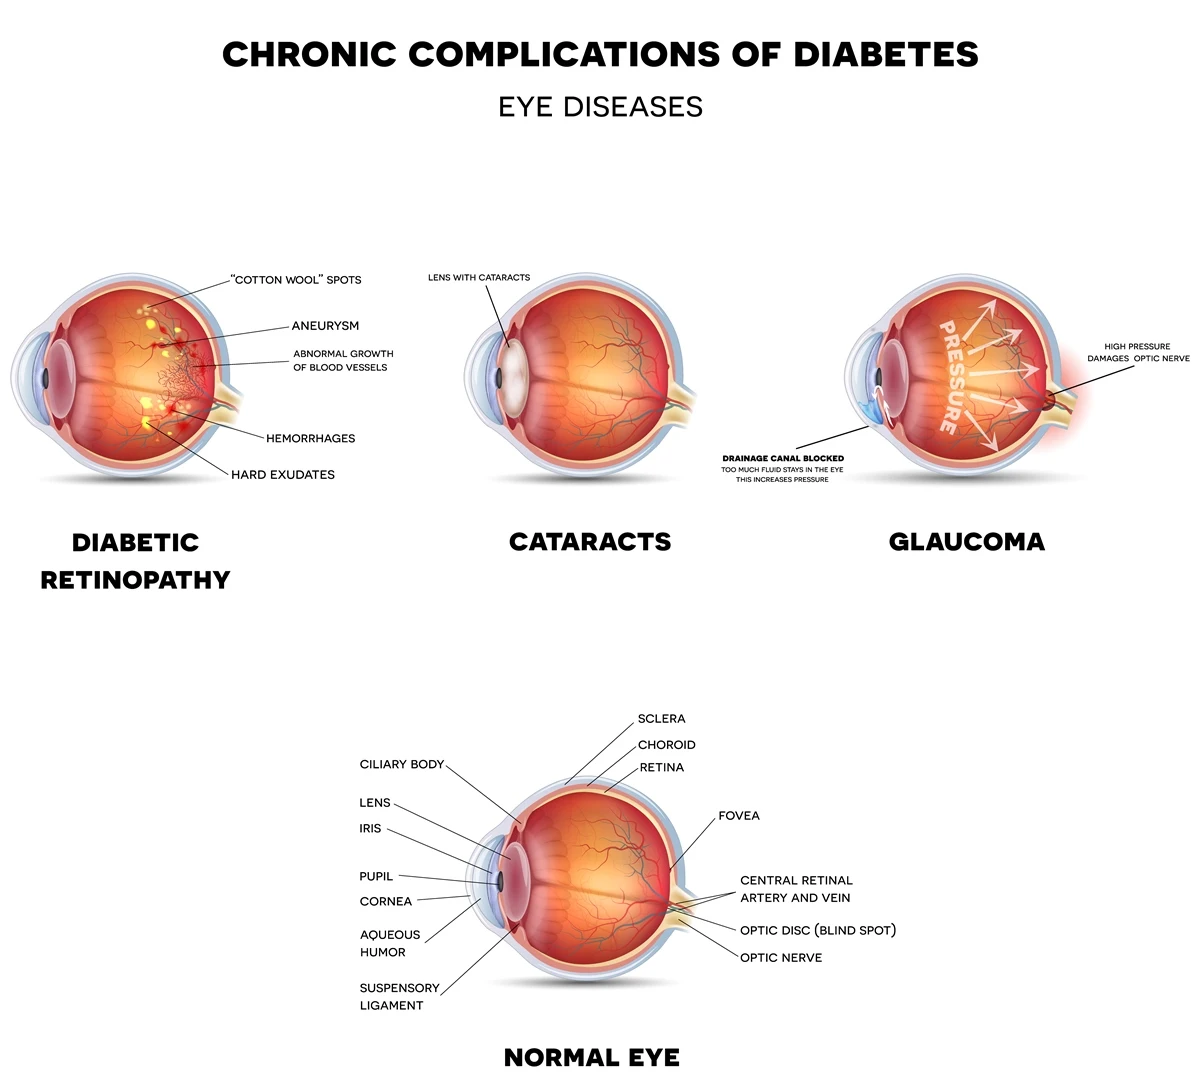

# About this notebook
#### In this notebook i will try to make a **comparison** between building and training a **nerual network from scratch** and using **Transfer learning(pretrained model)**, in terms of **trainig time, ease of creation, accuracy and consistancy**
#### This notebook was intented to be just a self trial to test the results, but i saw that it might help others so i tried to add insights and some references that might help

## Dataset Splitting and Directory Structure Preparation


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Original dataset path
src_dir = '/kaggle/input/eye-disease7/dataset'
# Target path where split datasets will be saved
target_dir = '/kaggle/working/split_dataset'

# Split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# create target directory folder

os.makedirs(target_dir, exist_ok=True)

for class_name in os.listdir(src_dir):
    class_path = os.path.join(src_dir, class_name)
    if not os.path.isdir(class_path):
        continue
        
#count images in every class  
    
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

#splits dataset 
    
    train_imgs, test_imgs = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
    val_imgs, test_imgs = train_test_split(test_imgs, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

#copies images into target directory folders    
    
    for split_name, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        split_class_dir = os.path.join(target_dir, split_name, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for img in split_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(split_class_dir, img))


### Dataset Distribution Verification (Class-wise Image Counts)


In [ ]:
#count images per set per class

import os

def count_images_per_class(split_dir, label):
    print(f"\n{label} set (per class):")
    for class_name in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        count = len([
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        print(f"  {class_name}: {count} images")
        
count_images_per_class('/kaggle/working/split_dataset/train', 'Train')
count_images_per_class('/kaggle/working/split_dataset/val', 'Validation')
count_images_per_class('/kaggle/working/split_dataset/test', 'Test')


### Total Images per Dataset Split (Before Augmentation)


In [ ]:
# count images per set

def count_total_images(directory, label):
    total = 0
    for root, _, files in os.walk(directory):
        total += len([f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    print(f"{label} set (before augmentation): {total} images")

count_total_images('/kaggle/working/split_dataset/train', 'Train')
count_total_images('/kaggle/working/split_dataset/val', 'Validation')
count_total_images('/kaggle/working/split_dataset/test', 'Test')


### Image Augmentation for Training Set (Rotation, Zoom, Flip, Brightness)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy as np


# Paths 
input_dir = '/kaggle/working/split_dataset'
aug_dir = '/kaggle/working/augmented_dataset'

# Iterates through each dataset split (train, val, test) and each class folder inside it.

#Creates matching folders inside augmented_dataset so the structure is ready.

for split in ['train', 'val', 'test']:
    for class_name in os.listdir(os.path.join(input_dir, split)):
        os.makedirs(os.path.join(aug_dir, split, class_name), exist_ok=True)

# Copy val and test without augmentation

for split in ['val', 'test']:
    for class_name in os.listdir(os.path.join(input_dir, split)):
        src = os.path.join(input_dir, split, class_name)
        dst = os.path.join(aug_dir, split, class_name)
        for img in os.listdir(src):
            if img.lower().endswith(('.jpg', '.jpeg', '.png')):
                shutil.copy(os.path.join(src, img), os.path.join(dst, img))


# Defines how images will be augmented

datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# For each class in the training set: Get the original path and the new save path.


for class_name in os.listdir(os.path.join(input_dir, 'train')):
    class_path = os.path.join(input_dir, 'train', class_name)
    save_path = os.path.join(aug_dir, 'train', class_name)

# Skip non-image files.    
    
    for img_name in os.listdir(class_path):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

# ensure each image are in RGB and convert them into numpy array
        
        img_path = os.path.join(class_path, img_name)
        image = Image.open(img_path).convert('RGB')
        x = np.array(image)
        x = x.reshape((1,) + x.shape)
        
# Save original image
        
        shutil.copy(img_path, os.path.join(save_path, img_name))
        
# Generate 3 augmentations per image
        
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=save_path, save_prefix='aug', save_format='jpeg'):
            i += 1
            if i >= 3:
                break


### Total Images per Dataset Split (After Augmentation)


In [ ]:
count_total_images('/kaggle/working/augmented_dataset/train', 'Train')
count_total_images('/kaggle/working/augmented_dataset/val', 'Validation')
count_total_images('/kaggle/working/augmented_dataset/test', 'Test')


### Loading Augmented Dataset and Rescaling Images for Model Training


In [ ]:
import tensorflow as tf



train = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/working/augmented_dataset/train',
    image_size=(224, 224),
    batch_size=64,
    shuffle=True
)

val = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/working/augmented_dataset/val',
    image_size=(224, 224),
    batch_size=64,
    shuffle=False
)

# Load raw test dataset
raw_test = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/working/augmented_dataset/test',
    image_size=(224, 224),
    batch_size=64,
    shuffle=False
)



# Extract class names immediately
class_names = raw_test.class_names


# Apply only rescaling (augmentation already applied and saved)
rescale = tf.keras.Sequential([tf.keras.layers.Rescaling(1./255)])
train = train.map(lambda x, y: (rescale(x), y))
val = val.map(lambda x, y: (rescale(x), y))
test = raw_test.map(lambda x, y: (rescale(x), y))


### DenseNet121-Based Custom Model Architecture for Multi-Class Retinal Disease Classification


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

def make_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    
    # Fine-tune deeper layers only
    for layer in base_model.layers[:83]:
        layer.trainable = False
    for layer in base_model.layers[83:]:
        layer.trainable = True

    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(0.45)(x)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(4, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = make_model()


### Training Callbacks: Early Stopping, Learning Rate Reduction, and Model Checkpointing


In [ ]:
from keras import callbacks

early_stop = callbacks.EarlyStopping(
    monitor="val_accuracy", patience=20, restore_best_weights=True, verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    'best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1
)


### Model Training with Early Stopping, Learning Rate Scheduling, and Checkpointing


In [ ]:
history = model.fit(
    train,
    validation_data=val,
    epochs=50,
    callbacks=[early_stop, reduce_lr, checkpoint]
)


### Installing VisualKeras for Model Architecture Visualization


In [ ]:
!pip install visualkeras


### Model Architecture Overview and Layered Visualization


In [ ]:
model.summary()
import visualkeras

visualkeras.layered_view(model,legend=True)

### Training and Validation Performance: Accuracy and Loss Curves


In [ ]:
import matplotlib.pyplot as plt


# Training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Set custom x-axis ticks: every 5 epochs
xticks = list(range(1, len(acc) + 1, 5))

plt.figure(figsize=(14, 6))

# --------- Accuracy Plot ---------
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'o-', color='green', label='Train', markersize=5)
plt.plot(epochs, val_acc, 'o-', color='red', label='Val', markersize=5)
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(xticks)
plt.ylim(min(min(acc), min(val_acc)) - 0.05, max(max(acc), max(val_acc)) + 0.05)
plt.legend()


# --------- Loss Plot ---------
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'o-', color='green', label='Train', markersize=5)
plt.plot(epochs, val_loss, 'o-', color='red', label='Val', markersize=5)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(xticks)
plt.ylim(min(min(loss), min(val_loss)) - 0.1, max(max(loss), max(val_loss)) + 0.1)
plt.legend()

plt.tight_layout()
plt.show()

### Generating Predictions and Extracting True Labels for Test Set Evaluation


In [ ]:
# Get Predictions and True Labels

# Get true labels and predictions from the test set
y_true = []
y_pred = []

for images, labels in test:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


### Displaying Class Names of the Dataset


In [ ]:
print(f"class_names: {class_names}")  # Should show a list like ['Cataract', 'Glaucoma', ...]


### Model Evaluation: Classification Report and Confusion Matrix


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Now class_names is available globally
print("Classes:", class_names)

# Convert test dataset to full numpy arrays
test_iter = test.as_numpy_iterator()
test_set = {"images": np.empty((0, 224, 224, 3)), "labels": np.empty(0)}

while True:
    try:
        batch = test_iter.next()
        test_set['images'] = np.concatenate((test_set['images'], batch[0]))
        test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
    except:
        break

y_true = test_set['labels']
y_pred = np.argmax(model.predict(test_set['images']), axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### ROC Curve Analysis (One-vs-Rest) for Multi-Class Classification


In [ ]:
#ROC Curve (One-vs-Rest)

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

# Binarize the output for ROC
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# Get prediction probabilities again
y_score = []

for images, _ in test:
    preds = model.predict(images)
    y_score.extend(preds)

y_score = np.array(y_score)

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



### Sample Test Predictions with Confidence Scores


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Unbatch the dataset to get individual images
test_unbatched = test.unbatch().take(12)

plt.figure(figsize=(15, 6))

for i, (img, label) in enumerate(test_unbatched):
    ax = plt.subplot(2, 6, i + 1)
    
    img_array = tf.expand_dims(img, 0)  # Add batch dimension
    prediction = model.predict(img_array, verbose=0)
    predicted_index = np.argmax(prediction)
    confidence = np.max(prediction) * 100  # Convert to percentage
    
    predicted_class = class_names[predicted_index]
    actual_class = class_names[label.numpy()]
    
    # Display image
    plt.imshow(img.numpy())
    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.1f}%", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

